In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sys
import pickle

sys.path.append('../scripts')
from helpers import create_model

from sklearn.model_selection import train_test_split, KFold

sns.set()

## Load data

In [25]:
with open('../data/presidentielle.pkl', 'rb') as f:
    data = pickle.load(f)

df1 = data['df1']
df2 = data['df2']

prop1 = data['prop1']
prop2 = data['prop2']

colnames = data['colnames']

del data

## Choosing a model

We will use k-fold cross-validation to identify the number of layers and neurons per layer. We first define a function that allows us to create a neural network using TensorFlow.

We now set the hyperparameters of the model that we will be testing. 

- `hidden_shape` is the number of neurons per layer
- `hidden_n_layer` is the number of hidden layers

In [26]:
model_params = np.meshgrid(
    [10, 20, 30, 40],
    [1, 2, 3, 4],
    [False]
)
model_params = np.array(model_params).T.reshape(-1, 3)
model_params = pd.DataFrame(
    model_params,
    columns=["hidden_shape", "hidden_n_layers", "batch_norm"])
model_params

,hidden_shape,hidden_n_layers,batch_norm
0,10,1,0
1,10,2,0
2,10,3,0
3,10,4,0
4,20,1,0
5,20,2,0
6,20,3,0
7,20,4,0
8,30,1,0
9,30,2,0


We now run the 10-fold cross-validation.

In [27]:
train_prop1, test_prop1, train_prop2, test_prop2 = train_test_split(
    prop1, prop2, test_size=.2, random_state=63)

nkf = 10
results = np.zeros((model_params.shape[0], nkf))
kf = KFold(nkf, random_state=63, shuffle=True)

for kf_idx, (train_idx, val_idx) in enumerate(kf.split(train_prop1)):
    for param_idx in range(model_params.shape[0]):

        hidden_shape = model_params["hidden_shape"][param_idx]
        hidden_n_layers = model_params["hidden_n_layers"][param_idx]
        batch_norm = model_params["batch_norm"][param_idx]

        model = create_model(
            input_shape=prop1.shape[1],
            output_shape=prop2.shape[1],
            hidden_shape=hidden_shape,
            hidden_n_layers=hidden_n_layers,
            batch_norm=batch_norm)

        model.fit(
            x=train_prop1.iloc[train_idx, :],
            y=train_prop2.iloc[train_idx, :],
            epochs=10,
            verbose=0)

        error = model.evaluate(
            x=train_prop1.iloc[val_idx, :],
            y=train_prop2.iloc[val_idx, :],
            verbose=0)
        results[param_idx, kf_idx] = error

        print(f'{kf_idx=}, {param_idx=} {error=:.4f}')


kf_idx=0, param_idx=0 error=0.0032
kf_idx=0, param_idx=1 error=0.0033
kf_idx=0, param_idx=2 error=0.0032
kf_idx=0, param_idx=3 error=0.0031
kf_idx=0, param_idx=4 error=0.0032
kf_idx=0, param_idx=5 error=0.0031
kf_idx=0, param_idx=6 error=0.0032
kf_idx=0, param_idx=7 error=0.0031
kf_idx=0, param_idx=8 error=0.0033
kf_idx=0, param_idx=9 error=0.0031
kf_idx=0, param_idx=10 error=0.0032
kf_idx=0, param_idx=11 error=0.0031
kf_idx=0, param_idx=12 error=0.0031
kf_idx=0, param_idx=13 error=0.0031
kf_idx=0, param_idx=14 error=0.0031
kf_idx=0, param_idx=15 error=0.0032
kf_idx=1, param_idx=0 error=0.0034
kf_idx=1, param_idx=1 error=0.0033
kf_idx=1, param_idx=2 error=0.0034
kf_idx=1, param_idx=3 error=0.0033
kf_idx=1, param_idx=4 error=0.0035
kf_idx=1, param_idx=5 error=0.0032
kf_idx=1, param_idx=6 error=0.0033
kf_idx=1, param_idx=7 error=0.0033
kf_idx=1, param_idx=8 error=0.0033
kf_idx=1, param_idx=9 error=0.0032
kf_idx=1, param_idx=10 error=0.0032
kf_idx=1, param_idx=11 error=0.0036
kf_idx=1, pa

We look at the distribution of errors for each model. There does not seem to be a significant difference in terms of prediction error between the models.

<AxesSubplot: xlabel='param_index', ylabel='value'>

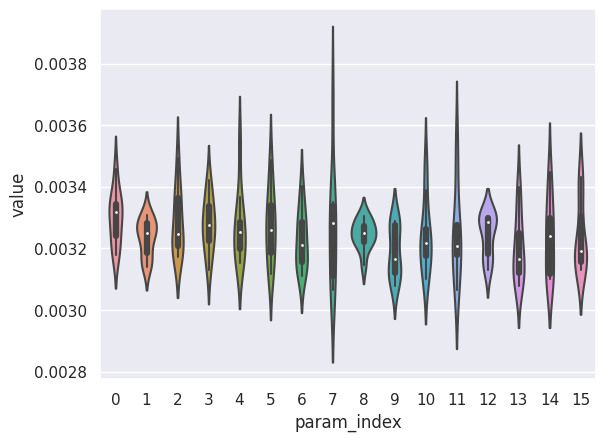

In [28]:
model_params_results = pd.concat([model_params, pd.DataFrame(results)], axis=1)
model_params_results["param_index"] = range(model_params_results.shape[0])

model_params_results_melt = model_params_results.melt(
    id_vars=list(model_params.columns)+["param_index"])

sns.violinplot(model_params_results_melt, x="param_index", y="value")

We look at the median error for each model. We that 2 hidden layers with 30 neurons per layer seem to give the best results.

In [29]:
(model_params_results_melt
    .groupby(list(model_params.columns))["value"]
    .median()
    .sort_values())

hidden_shape  hidden_n_layers  batch_norm
30            2                0             0.003166
40            2                0             0.003167
              4                0             0.003192
30            4                0             0.003209
20            3                0             0.003212
30            3                0             0.003219
40            3                0             0.003242
10            3                0             0.003247
30            1                0             0.003250
10            2                0             0.003250
20            1                0             0.003252
              2                0             0.003260
10            4                0             0.003276
20            4                0             0.003281
40            1                0             0.003287
10            1                0             0.003317
Name: value, dtype: float64

## Estimating test error

We now estimate the test error of this model.

In [33]:
model = create_model(
    input_shape=prop1.shape[1],
    output_shape=prop2.shape[1],
    hidden_shape=30,
    hidden_n_layers=2,
    batch_norm=False)
    
history = model.fit(
    x=train_prop1, 
    y=train_prop2,
    epochs=50, 
    validation_split=.1,
    verbose=0)

In [34]:
model.evaluate(
    x=test_prop1,
    y=test_prop2,
    verbose=0)

0.002976600546389818

<AxesSubplot: >

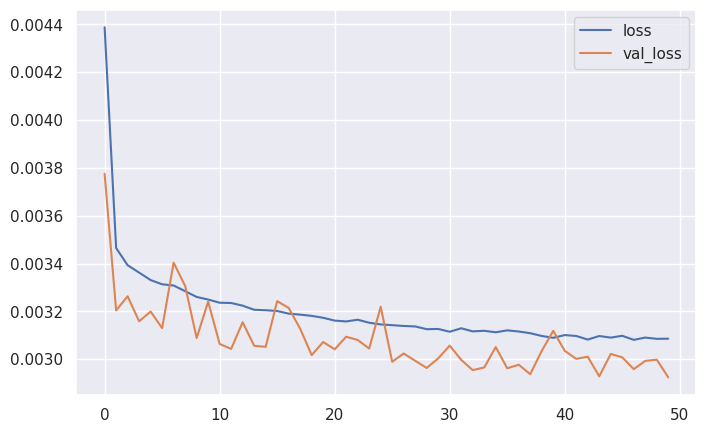

In [35]:
pd.DataFrame(history.history).plot(figsize=(8, 5))